<a href="https://colab.research.google.com/github/VeenaShirsath/COMPSCI590/blob/main/COMPSCI590_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries and settings

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import NearestNeighbors
import scipy

from numpy import mean
from numpy import var
from math import sqrt

sns.set()

pd.set_option('display.max_columns', None)

## Data Generating Process

In [ ]:
def construct_sec_order(arr):
    # an intermediate data generation function used for generating second order information
    second_order_feature = []
    num_cov_sec = len(arr[0])
    for a in arr:
        tmp = []
        for i in range(num_cov_sec):
            for j in range(i+1, num_cov_sec):
                tmp.append( a[i] * a[j] )
        second_order_feature.append(tmp)
    return np.array(second_order_feature)

In [ ]:
def data_generation_dense_endo(num_samples, num_cov_dense, num_covs_unimportant, rho=0, enforce_overlap=True):
    def u(x):
        T = []
        for row in x:
            # Use multiple covariates to determine treatment, normalized
            score = (row[0] + row[1] + row[2]) / 3
            prob = scipy.special.expit(score)  # sigmoid function to smooth probabilities
            if enforce_overlap:
                # Clip probabilities to [0.1, 0.9] to ensure overlap
                prob = np.clip(prob, 0.1, 0.9)
            t = np.random.binomial(1, prob)
            T.append(t)
        return np.array(T)

    mu = np.ones((num_samples, num_cov_dense))
    sigma = (1 - rho) * np.eye(num_cov_dense) + rho * np.ones((num_cov_dense, num_cov_dense))
    x = np.matmul(np.random.normal(0, 0.5, size=(num_samples, num_cov_dense)), sigma) + mu

    errors = np.random.normal(0, 1, size=num_samples)

    dense_bs_sign = np.random.choice([-1, 1], num_cov_dense)
    dense_bs = [dense_bs_sign[i] * 10. * (1. / 2 ** (i + 1)) for i in range(num_cov_dense)]

    treatment_eff_coef = np.random.normal(1.0, 0.5, size=num_cov_dense)
    treatment_effect = np.dot(x, treatment_eff_coef)
    second = construct_sec_order(x[:, :num_cov_dense])
    treatment_eff_sec = np.sum(second, axis=1)

    x2 = np.random.normal(1, 1.5, size=(num_samples, num_covs_unimportant))

    T = u(x)

    y0 = np.dot(x, np.array(dense_bs)) + errors
    y1 = y0 + (treatment_effect + treatment_eff_sec)  # treatment effect added on top of y0
    y = T * y1 + (1 - T) * y0
    te = y1 - y0

    df = pd.DataFrame(np.hstack([x, x2]), columns=['X%d' % j for j in range(num_cov_dense + num_covs_unimportant)])
    df['Y'] = y
    df['T'] = T

    df_true = pd.DataFrame()
    df_true['Y1'] = y1
    df_true['Y0'] = y0
    df_true['TE'] = te

    return df, df_true

In [ ]:
df, df_true = data_generation_dense_endo(num_samples=1000, num_cov_dense=50, num_covs_unimportant=50)

In [ ]:
# Calculate true ATE
true_ate = df_true['TE'].mean()
print("True ATE:", true_ate)

True ATE: 1270.8178773177171


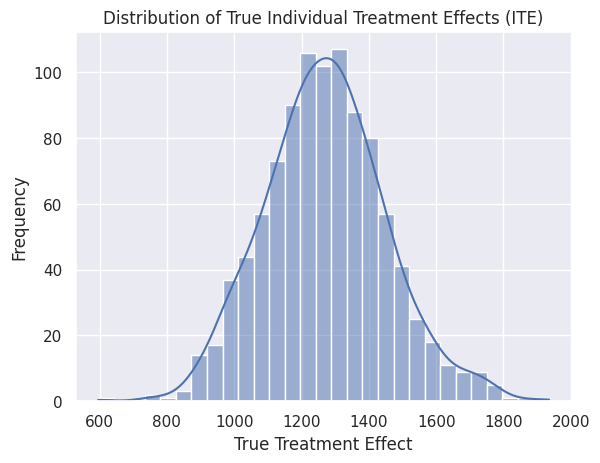

In [ ]:
sns.histplot(df_true['TE'], kde=True)
plt.title("Distribution of True Individual Treatment Effects (ITE)")
plt.xlabel("True Treatment Effect")
plt.ylabel("Frequency")
plt.show()

In [ ]:
df.to_csv('MALTS_DGS_df_n1000_x100.csv', index=False)

In [ ]:
df = pd.read_csv('MALTS_DGS_df_n1000_x100.csv')
df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,Y,T
0,1.383052,0.405645,1.008311,1.640810,0.772118,0.059750,1.300545,0.950349,2.410032,0.602359,0.847481,0.572565,1.460799,0.698294,1.035816,1.697761,1.247360,0.713979,0.072422,1.027555,0.931534,0.945130,0.755862,1.665384,0.483629,0.584702,0.712614,1.426936,1.536741,0.740669,1.170054,1.863182,0.880419,0.820414,1.884986,0.955257,0.967699,1.783858,1.004393,1.072017,1.399124,0.900778,0.712124,1.116610,0.617025,1.438489,1.170869,1.576927,0.618531,0.192383,1.366201,-1.545396,2.425635,1.553500,4.546462,3.160770,2.601173,1.610596,0.964329,-0.699351,0.672389,2.713203,2.470436,2.367371,0.301938,-1.431776,0.862005,1.703914,0.344010,2.093804,-2.247760,1.762678,2.478686,3.660732,0.651017,-2.189770,0.847713,-0.139593,2.680925,-1.024944,1.460261,2.106609,0.608938,-0.388155,0.968056,1.838220,-1.961584,0.726619,-3.227211,0.349590,2.719471,0.512670,1.098402,1.238871,0.119069,0.679077,1.962060,0.442936,3.041139,3.115545,1351.044999,1
1,1.140693,0.521626,1.044330,1.042933,1.578944,0.669209,0.439530,0.876596,0.609297,1.002869,0.569519,1.057925,1.401915,1.200741,0.251238,0.758115,0.913953,1.148696,1.254361,1.273470,0.926647,1.463834,0.851417,0.068146,0.240047,1.114902,1.372594,1.688885,0.242531,0.583738,1.728995,0.664383,0.937065,0.928930,1.387022,0.963111,2.034344,0.810327,1.247482,1.257242,0.935382,0.000479,2.130463,0.064949,1.731686,1.416809,1.488813,1.448175,1.367795,0.845892,-0.350394,-2.128173,-0.229513,2.153665,0.355774,-0.761475,-3.509252,1.549099,4.033163,1.756706,2.398017,3.414205,0.673375,-0.105857,0.232624,-0.504645,1.418108,-0.140852,3.580334,2.539216,2.653842,2.114754,1.191987,0.834904,-1.037591,-1.896345,0.650409,0.046002,1.563952,1.143959,1.208157,0.835518,1.741013,-0.866473,1.022373,-1.101116,-1.123431,-0.852409,2.322059,0.257874,0.092110,0.456561,0.360194,2.268624,1.178340,1.367980,0.360759,1.519539,0.873100,0.445397,1297.398463,1
2,0.701328,0.887016,1.282548,1.259921,1.062105,0.536024,1.601137,1.113285,1.717285,1.509119,0.923674,0.774111,1.563494,0.529168,1.061940,0.696448,1.042910,0.957568,0.947484,1.759474,1.296860,1.932806,0.915544,1.020977,0.819387,1.362268,1.031720,0.788315,0.732271,0.729022,0.437248,0.083887,0.800816,0.333803,1.023034,1.588590,0.423860,1.809018,1.190402,1.368293,0.722810,0.261322,1.149330,0.636921,1.220572,1.318500,1.660815,0.691217,1.268718,1.182752,0.447709,0.673723,1.608861,1.734249,0.367227,-1.669440,-0.166350,1.029226,-1.330482,0.468054,1.251451,1.183066,1.073753,2.151011,0.080558,-0.506796,-0.757791,1.589651,0.740912,3.093771,2.591131,0.077105,2.105259,-1.712673,2.287794,1.158117,-0.093489,2.149814,0.392260,2.923886,1.004550,1.872669,0.241490,1.110267,2.476321,2.229620,0.782751,0.328692,1.616112,-0.074931,-1.821822,2.095258,1.321382,-0.524400,-3.525166,1.360211,0.050124,-0.055726,-1.043483,-1.021165,1348.856676,1
3,1.492068,0.923296,1.434351,0.334877,0.776074,0.566694,0.976163,0.260752,1.524200,1.178947,1.559873,0.982179,0.735387,0.607519,1.463922,0.543530,1.196163,0.770956,1.386764,0.710458,1.772047,1.019831,0.529380,-0.505090,0.596066,0.486605,0.433679,1.433585,0.765829,0.771725,1.437277,0.606219,-0.244444,0.454021,0.312817,1.040276,0.983884,1.680679,1.182232,0.763831,0.964090,-0.503059,1.527959,1.124868,1.474965,0.148078,0.952793,1.654043,1.778563,-0.133424,-1.708002,1.425772,0.805092,-0.367564,0.120499,0.644037,0.119151,-0.502212,2.807756,-0.042096,1.823359,0.363373,2.259835,0.865786,0.981572,0.867557,0.188825,2.314675,0.468618,-0.637447,2.684577,1.422767,1.182608,-0.923842,2.606929,1.883549,0.735220,2.796794,1.326817,2.511452,0.503962,4.101974,2.381753,2.243355,2.379455,0.375818,-0.036073,0.685169,1.480281,1.880

## Matching methods

### V: Propensity score
Source code: https://www.kaggle.com/code/harrywang/propensity-score-matching-in-python

Not a stable library: https://pypi.org/project/psmpy/#predict-scores

Another source: https://towardsdatascience.com/causal-inference-with-python-a-guide-to-propensity-score-matching-b3470080c84f/



In [ ]:
df.groupby('T').mean()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,Y
T,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.998390,0.904382,0.904662,0.956925,1.022346,0.955868,1.021662,1.025926,1.046647,0.981848,1.016317,0.991205,0.983709,0.978293,0.970279,1.029834,0.996145,0.985834,1.011122,0.960999,1.014119,1.000717,0.986938,1.004980,1.004961,0.999466,1.013326,1.001667,0.993276,0.980728,0.958976,1.027467,0.978845,0.996581,1.040153,1.029625,0.991691,1.014578,1.000955,1.007127,1.017422,0.991768,1.004124,0.989257,0.985153,0.980140,1.026952,1.018180,0.961393,0.979607,0.877606,1.048230,0.995950,1.183454,1.121731,0.939544,0.995647,0.816130,0.928773,0.917183,0.909620,0.880011,0.998525,0.808176,0.959553,1.000906,1.127764,0.814007,1.081669,0.980937,0.971771,0.898649,0.992730,1.067754,0.871908,0.896648,0.882108,0.980095,0.943742,1.103195,1.065559,1.025891,0.999940,1.055909,1.014945,1.232915,1.146409,0.963451,1.014819,1.120835,1.025185,0.868306,1.047562,1.076163,0.982481,1.004215,1.107822,0.848778,0.898854,0.958518,-8.898797
1,1.019826,1.012247,0.994659,0.975288,1.037452,0.989006,1.023790,0.962071,1.024851,1.003866,1.011648,1.021094,0.975302,1.002448,1.020917,0.971474,0.999166,1.003169,1.011264,1.017675,1.006878,0.984500,1.006203,1.022571,0.987790,0.990868,0.964785,1.007644,1.021123,0.980987,0.998796,1.021363,1.010067,0.984053,1.009700,1.014062,0.960569,0.995005,0.975070,0.985020,1.015323,1.002292,1.013982,1.012555,0.971506,1.023498,0.968122,0.978984,0.982105,0.993984,0.951748,0.938439,0.987954,1.018838,1.025484,0.899547,0.941478,0.935847,0.922031,0.963932,0.991883,0.957818,0.956222,1.001220,1.019310,1.038331,0.998088,1.089641,0.916669,0.951858,0.976336,0.993916,0.971292,0.903613,1.037675,1.006800,0.964634,0.892502,1.003293,0.941518,0.986641,0.966186,1.101762,1.040056,0.984767,0.964851,1.027472,1.072117,1.058078,0.925216,1.058147,0.864373,0.964281,1.082025,0.925659,0.913283,1.046797,1.009742,0.914139,1.044714,1264.841161


In [ ]:
# separate control and treatment for t-test
df_control = df[df['T']==0]
df_treatment = df[df['T']==1]

In [ ]:
print(df_control.Y.mean(), df_treatment.Y.mean())

# compare samples
_, p = ttest_ind(df_control.Y, df_treatment.Y)
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

-8.89879737657446 1264.8411611518343
p=0.000
different distributions/different group mean (reject H0)


In [ ]:
X = df[[f'X{i}' for i in range(100)]]

T = df['T']

Y = df['Y']

##### Start runtime

In [ ]:
import time

start_time = time.perf_counter()

In [ ]:
# use logistic regression to calculate the propensity scores
lr = LogisticRegression(max_iter=1000, solver='liblinear')
lr.fit(X, T)

LogisticRegression(max_iter=1000, solver='liblinear')

In [ ]:
# prediction
pred_binary = lr.predict(X)  # binary 0 control, 1, treatment
pred_prob = lr.predict_proba(X)  # probabilities for classes

#print('the binary prediction is:', pred_binary[0])
#print('the corresponding probabilities are:', pred_prob[0])

In [ ]:
df['ps'] = pred_prob[:, 1] # the propensity score (ps) is the probability of being 1 (i.e., in the treatment group)
#matching_df_new = matching_df[(matching_df['ps'] < 0.99) | (matching_df['ps'] < 0.01)]

In [ ]:
# Assuming matching_df is your DataFrame
caliper = np.std(df['ps']) * 0.25
print(f'caliper (radius) is: {caliper:.4f}')

n_neighbors = 10

# Setup the knn model
knn = NearestNeighbors(n_neighbors=n_neighbors, radius=caliper)

# Reshape the 'ps' column to be 2D
ps = df['ps'].values.reshape(-1, 1)  # Reshape to (n_samples, 1)

# Fit the model
knn.fit(ps)

caliper (radius) is: 0.0238


NearestNeighbors(n_neighbors=10, radius=0.023771070787768505)

In [ ]:
# distances and indexes
distances, neighbor_indexes = knn.kneighbors(ps)

#print(neighbor_indexes.shape)

# the 10 closest points to the first point
#print(distances[0])
#print(neighbor_indexes[0])

In [ ]:
# for each point in treatment, we find a matching point in control without replacement
# note the 10 neighbors may include both points in treatment and control

matched_control = []  # keep track of the matched observations in control

for current_index, row in df.iterrows():  # iterate over the dataframe
    if row['T'] == 0:  # the current row is in the control group
        df.loc[current_index, 'matched'] = np.nan  # set matched to nan
    else:
        for idx in neighbor_indexes[current_index, :]: # for each row in treatment, find the k neighbors
            # make sure the current row is not the idx - don't match to itself
            # and the neighbor is in the control
            if (current_index != idx) and (df.loc[idx, 'T'] == 0):
                if idx not in matched_control:  # this control has not been matched yet
                    df.loc[current_index, 'matched'] = idx  # record the matching
                    matched_control.append(idx)  # add the matched to the list
                    break

In [ ]:
# control have no match
treatment_matched = df.dropna(subset=['matched'])  # drop not matched

# matched control observation indexes
control_matched_idx = treatment_matched.matched
control_matched_idx = control_matched_idx.astype(int)  # change to int
control_matched = df.loc[control_matched_idx, :]  # select matched control observations

# combine the matched treatment and control
df_matched = pd.concat([treatment_matched, control_matched])

#df_matched['T'].value_counts()

In [ ]:
# matched control and treatment
df_matched_control = df_matched[df_matched['T']==0]
df_matched_treatment = df_matched[df_matched['T']==1]

In [ ]:
for _ in range(1000000):
    pass

end_time = time.perf_counter()

execution_time = end_time - start_time

print(f"The code took {execution_time} seconds to run.")

The code took 9.897793182999976 seconds to run.


##### End runtime and find ATE

In [ ]:
ATE = df_matched_treatment['Y'].mean() - df_matched_control['Y'].mean()
print(f"Average Treatment Effect (ATE): {ATE}")

Average Treatment Effect (ATE): 1269.690111186907


In [ ]:
def logit(p):
    logit_value = math.log(p / (1-p))
    return logit_value

df['ps_logit'] = df.ps.apply(lambda x: logit(x))

#df.head()

In [ ]:
# get the coefficients
lr.coef_.ravel()  # or reshape(-1) refers to an unknown dimension, often used to flatten the array

# get the feature names
X.columns.to_numpy()

# combine features and coefficients into a dataframe
coeffs = pd.DataFrame({
    'column':X.columns.to_numpy(),
    'coeff':lr.coef_.ravel(),
})
#coeffs

In [ ]:
# student's t-test for revenue (dependent variable) after matching
# p value is not significant now
print(df_matched_control['Y'].mean(), df_matched_treatment['Y'].mean())

# compare samples
_, p = ttest_ind(df_matched_control['Y'], df_matched_treatment['Y'])
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

-3.691587590830888 2833.9635218023845
p=0.000
different distributions/different group mean (reject H0)


In [ ]:
# try to increase the number of neighbors and/or caliper to get more matches
print('total observations in treatment:', len(df[df['T']==1]))
print('total matched observations in control:', len(matched_control))

total observations in treatment: 720
total matched observations in control: 220


<Axes: xlabel='ps', ylabel='Count'>

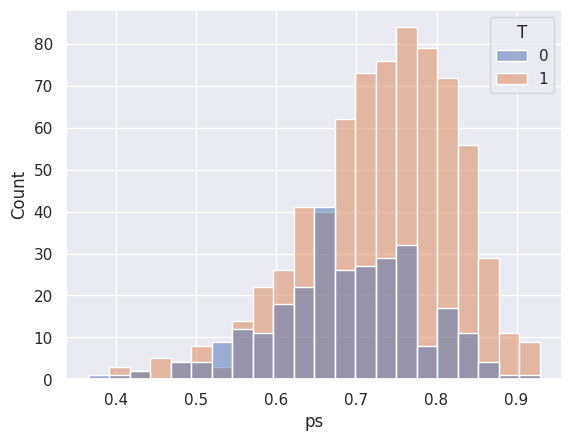

In [ ]:
# check the overlap of ps for control and treatment using histogram
# if not much overlap, the matching won't work
sns.histplot(data=df, x='ps', hue='T')  # multiple="dodge" for

### V: MALTS

* is this using the generalized Mahamlanobis distance for continuous data?

In [ ]:
import scipy.optimize as opt
import sklearn.linear_model as lm
import sklearn.ensemble as ensemble
import sklearn.gaussian_process as gp
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import matplotlib.patches as patches
from sklearn.model_selection import RepeatedStratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#cols = ['X0','X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X107', 'X108', 'X109', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X120', 'X121', 'X122', 'X123', 'X124', 'X125', 'X126', 'X127', 'X128', 'X129', 'X130', 'X131', 'X132', 'X133', 'X134', 'X135', 'X136', 'X137', 'X138', 'X139', 'X140', 'X141', 'X142', 'X143', 'X144', 'X145', 'X146', 'X147', 'X148', 'X149','Y','T']
cols = df[[f'X{i}' for i in range(50)]]


In [ ]:
cols

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49
0,1.383052,0.405645,1.008311,1.640810,0.772118,0.059750,1.300545,0.950349,2.410032,0.602359,0.847481,0.572565,1.460799,0.698294,1.035816,1.697761,1.247360,0.713979,0.072422,1.027555,0.931534,0.945130,0.755862,1.665384,0.483629,0.584702,0.712614,1.426936,1.536741,0.740669,1.170054,1.863182,0.880419,0.820414,1.884986,0.955257,0.967699,1.783858,1.004393,1.072017,1.399124,0.900778,0.712124,1.116610,0.617025,1.438489,1.170869,1.576927,0.618531,0.192383
1,1.140693,0.521626,1.044330,1.042933,1.578944,0.669209,0.439530,0.876596,0.609297,1.002869,0.569519,1.057925,1.401915,1.200741,0.251238,0.758115,0.913953,1.148696,1.254361,1.273470,0.926647,1.463834,0.851417,0.068146,0.240047,1.114902,1.372594,1.688885,0.242531,0.583738,1.728995,0.664383,0.937065,0.928930,1.387022,0.963111,2.034344,0.810327,1.247482,1.257242,0.935382,0.000479,2.130463,0.064949,1.731686,1.416809,1.488813,1.448175,1.367795,0.845892
2,0.701328,0.887016,1.282548,1.259921,1.062105,0.536024,1.601137,1.113285,1.717285,1.509119,0.923674,0.774111,1.563494,0.529168,1.061940,0.696448,1.042910,0.957568,0.947484,1.759474,1.296860,1.932806,0.915544,1.020977,0.819387,1.362268,1.031720,0.788315,0.732271,0.729022,0.437248,0.083887,0.800816,0.333803,1.023034,1.588590,0.423860,1.809018,1.190402,1.368293,0.722810,0.261322,1.149330,0.636921,1.220572,1.318500,1.660815,0.691217,1.268718,1.182752
3,1.492068,0.923296,1.434351,0.334877,0.776074,0.566694,0.976163,0.260752,1.524200,1.178947,1.559873,0.982179,0.735387,0.607519,1.463922,0.543530,1.196163,0.770956,1.386764,0.710458,1.772047,1.019831,0.529380,-0.505090,0.596066,0.486605,0.433679,1.433585,0.765829,0.771725,1.437277,0.606219,-0.244444,0.454021,0.312817,1.040276,0.983884,1.680679,1.182232,0.763831,0.964090,-0.503059,1.527959,1.124868,1.474965,0.148078,0.952793,1.654043,1.778563,-0.133424
4,0.734775,1.672705,0.767097,0.566046,0.790900,1.375120,0.523701,1.437692,1.128897,0.219999,1.526383,0.174531,1.413672,1.162824,1.500408,1.068586,1.772325,1.191610,0.947326,0.782223,1.012256,1.602489,1.246371,2.068639,-0.490057,1.167143,0.163777,1.074801,1.043838,1.919812,1.206538,0.685164,1.641226,1.043063,1.140691,0.809922,0.614236,1.233915,-0.019096,1.500126,1.119881,1.069800,1.002493,0.250769,0.969338,1.585010,1.230194,1.321216,1.571343,1.657305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2.400942,0.875339,0.380871,1.500993,1.986837,0.761480,1.606464,1.743346,1.599336,0.083042,0.888580,0.885968,0.597987,0.503534,1.259553,1.255091,1.233145,0.229973,0.755457,0.749912,0.862974,2.022502,0.909609,-0.039504,0.463343,-0.267651,0.658232,2.186259,1.587622,0.890171,0.013837,1.491127,0.904211,1.085897,0.857801,1.522696,1.069593,0.870761,0.586966,1.208634,1.500175,-0.015182,1.013994,0.704645,1.276771,0.885970,1.680355,0.702337,0.577030,1.119622
996,1.134875,0.748726,0.930753,0.859371,0.752543,1.324135,0.432591,1.318847,0.960902,1.109177,1.482371,1.115307,0.386192,0.567192,1.324081,1.715666,0.551603,1.142240,1.394856,0.608615,0.611904,1.112121,0.844297,-0.465951,1.170720,1.082214,0.355220,0.218414,-0.153933,0.656456,1.516069,0.668272,0.726545,-0.234810,1.140269,1.036081,1.556003,1.440914,0.977794,0.732589,1.855418,0.762641,1.846443,0.542731,0.742089,1.524352,1.871546,0.972059,0.167243,1.134480
997,0.862829,0.208245,0.186182,1.074979,1.580999,1.172231,0.754385,1.079362,1.021891,-0.116237,1.442759,1.186210,1.017052,1.833558,2.152977,1.469870,1.126055,1.640068,0.663892,0.592492,1.275111,0.689059,1.338757,-0.134801,1.025758,0.254789,1.288801,1.288950,1.530709,1.061569,1.457158,0.925720,0.582812,1.299868,1.014656,1.129349,1.896972,0.786159,0.720879,0.185591,2.209842,1.835282,1.150373,0.563037,0.813106,0.812973,0.341

##### Start runtime

In [ ]:
import time

start_time = time.perf_counter()

In [ ]:
class malts:
    def __init__(self,outcome,treatment,data,discrete=[],C=1,k=10,reweight=False):
        # np.random.seed(0)
        self.C = C #coefficient to regularozation term
        self.k = k
        self.reweight = reweight
        self.n, self.p = data.shape
        self.p = self.p - 2 #shape of the data
        self.outcome = outcome
        self.treatment = treatment
        self.discrete = discrete
        self.continuous = list(set(data.columns).difference(set([outcome]+[treatment]+discrete)))
        #splitting the data into control and treated units
        self.df_T = data.loc[data[treatment]==1]
        self.df_C = data.loc[data[treatment]==0]
        #extracting relevant covariates (discrete,continuous)
        #and outcome. Converting to numpy array.
        self.Xc_T = self.df_T[self.continuous].to_numpy()
        self.Xc_C = self.df_C[self.continuous].to_numpy()
        self.Xd_T = self.df_T[self.discrete].to_numpy()
        self.Xd_C = self.df_C[self.discrete].to_numpy()
        self.Y_T = self.df_T[self.outcome].to_numpy()
        self.Y_C = self.df_C[self.outcome].to_numpy()
        self.del2_Y_T = ((np.ones((len(self.Y_T),len(self.Y_T)))*self.Y_T).T - (np.ones((len(self.Y_T),len(self.Y_T)))*self.Y_T))**2
        self.del2_Y_C = ((np.ones((len(self.Y_C),len(self.Y_C)))*self.Y_C).T - (np.ones((len(self.Y_C),len(self.Y_C)))*self.Y_C))**2

        self.Dc_T = np.ones((self.Xc_T.shape[0],self.Xc_T.shape[1],self.Xc_T.shape[0])) * self.Xc_T.T
        self.Dc_T = (self.Dc_T - self.Dc_T.T)
        self.Dc_C = np.ones((self.Xc_C.shape[0],self.Xc_C.shape[1],self.Xc_C.shape[0])) * self.Xc_C.T
        self.Dc_C = (self.Dc_C - self.Dc_C.T)

        self.Dd_T = np.ones((self.Xd_T.shape[0],self.Xd_T.shape[1],self.Xd_T.shape[0])) * self.Xd_T.T
        self.Dd_T = (self.Dd_T != self.Dd_T.T)
        self.Dd_C = np.ones((self.Xd_C.shape[0],self.Xd_C.shape[1],self.Xd_C.shape[0])) * self.Xd_C.T
        self.Dd_C = (self.Dd_C != self.Dd_C.T)

    def threshold(self,x):
        k = self.k
        for i in range(x.shape[0]):
            row = x[i,:]
            row1 = np.where( row < row[np.argpartition(row,k+1)[k+1]],1,0)
            x[i,:] = row1
        return x

    def distance(self,Mc,Md,xc1,xd1,xc2,xd2):
        dc = np.dot((Mc**2)*(xc1-xc2),(xc1-xc2))
        dd = np.sum((Md**2)*xd1!=xd2)
        return dc+dd

    def loss_(self, Mc, Md, xc1, xd1, y1, xc2, xd2, y2, gamma=1 ):
        w12 = np.exp( -1 * gamma * self.distance(Mc,Md,xc1,xd1,xc2,xd2) )
        return w12*((y1-y2)**2)

    def calcW_T(self,Mc,Md):
        #this step is slow
        Dc = np.sum( ( self.Dc_T * (Mc.reshape(-1,1)) )**2, axis=1)
        Dd = np.sum( ( self.Dd_T * (Md.reshape(-1,1)) )**2, axis=1)
        W = self.threshold( (Dc + Dd) )
        W = W / (np.sum(W,axis=1)-np.diag(W)).reshape(-1,1)
        return W

    def calcW_C(self,Mc,Md):
        #this step is slow
        Dc = np.sum( ( self.Dc_C * (Mc.reshape(-1,1)) )**2, axis=1)
        Dd = np.sum( ( self.Dd_C * (Md.reshape(-1,1)) )**2, axis=1)
        W = self.threshold( (Dc + Dd) )
        W = W / (np.sum(W,axis=1)-np.diag(W)).reshape(-1,1)
        return W

    def Delta_(self,Mc,Md):
        self.W_T = self.calcW_T(Mc,Md)
        self.W_C = self.calcW_C(Mc,Md)
        self.delta_T = np.sum((self.Y_T - (np.matmul(self.W_T,self.Y_T) - np.diag(self.W_T)*self.Y_T))**2)
        self.delta_C = np.sum((self.Y_C - (np.matmul(self.W_C,self.Y_C) - np.diag(self.W_C)*self.Y_C))**2)
        if self.reweight == False:
            return self.delta_T + self.delta_C
        elif self.reweight == True:
            return (len(self.Y_T)+len(self.Y_C))*(self.delta_T/len(self.Y_T) + self.delta_C/len(self.Y_C))

    def objective(self,M):
        Mc = M[:len(self.continuous)]
        Md = M[len(self.continuous):]
        delta = self.Delta_(Mc,Md)
        reg = self.C * ( np.linalg.norm(Mc,ord=2)**2 + np.linalg.norm(Md,ord=2)**2 )
        cons1 = 0 * ( (np.sum(Mc) + np.sum(Md)) - self.p )**2
        cons2 = 1e+25 * np.sum( ( np.concatenate((Mc,Md)) < 0 ) )
        return delta + reg + cons1 + cons2

    def fit(self,method='COBYLA'):
        # np.random.seed(0)
        M_init = np.ones((self.p,))
        res = opt.minimize( self.objective, x0=M_init,method=method )
        self.M = res.x
        self.Mc = self.M[:len(self.continuous)]
        self.Md = self.M[len(self.continuous):]
        self.M_opt = pd.DataFrame(self.M.reshape(1,-1),columns=self.continuous+self.discrete,index=['Diag'])
        return res

    def get_matched_groups(self, df_estimation, k=10 ):
        #units to be matched
        Xc = df_estimation[self.continuous].to_numpy()
        Xd = df_estimation[self.discrete].to_numpy()
        Y = df_estimation[self.outcome].to_numpy()
        T = df_estimation[self.treatment].to_numpy()
        #splitted estimation data for matching
        df_T = df_estimation.loc[df_estimation[self.treatment]==1]
        df_C = df_estimation.loc[df_estimation[self.treatment]==0]
        #converting to numpy array
        Xc_T = df_T[self.continuous].to_numpy()
        Xc_C = df_C[self.continuous].to_numpy()
        Xd_T = df_T[self.discrete].to_numpy()
        Xd_C = df_C[self.discrete].to_numpy()
        Y_T = df_T[self.outcome].to_numpy()
        Y_C = df_C[self.outcome].to_numpy()
        D_T = np.zeros((Y.shape[0],Y_T.shape[0]))
        D_C = np.zeros((Y.shape[0],Y_C.shape[0]))
        #distance_treated
        Dc_T = (np.ones((Xc_T.shape[0],Xc.shape[1],Xc.shape[0])) * Xc.T - (np.ones((Xc.shape[0],Xc.shape[1],Xc_T.shape[0])) * Xc_T.T).T)
        Dc_T = np.sum( (Dc_T * (self.Mc.reshape(-1,1)) )**2 , axis=1 )
        Dd_T = (np.ones((Xd_T.shape[0],Xd.shape[1],Xd.shape[0])) * Xd.T != (np.ones((Xd.shape[0],Xd.shape[1],Xd_T.shape[0])) * Xd_T.T).T )
        Dd_T = np.sum( (Dd_T * (self.Md.reshape(-1,1)) )**2 , axis=1 )
        D_T = (Dc_T + Dd_T).T
        #distance_control
        Dc_C = (np.ones((Xc_C.shape[0],Xc.shape[1],Xc.shape[0])) * Xc.T - (np.ones((Xc.shape[0],Xc.shape[1],Xc_C.shape[0])) * Xc_C.T).T)
        Dc_C = np.sum( (Dc_C * (self.Mc.reshape(-1,1)) )**2 , axis=1 )
        Dd_C = (np.ones((Xd_C.shape[0],Xd.shape[1],Xd.shape[0])) * Xd.T != (np.ones((Xd.shape[0],Xd.shape[1],Xd_C.shape[0])) * Xd_C.T).T )
        Dd_C = np.sum( (Dd_C * (self.Md.reshape(-1,1)) )**2 , axis=1 )
        D_C = (Dc_C + Dd_C).T
        MG = {}
        index = df_estimation.index
        for i in range(Y.shape[0]):
            #finding k closest control units to unit i
            idx = np.argpartition(D_C[i,:],k)
            matched_df_C = pd.DataFrame( np.hstack( (Xc_C[idx[:k],:], Xd_C[idx[:k],:].reshape((k,len(self.discrete))), Y_C[idx[:k]].reshape(-1,1), D_C[i,idx[:k]].reshape(-1,1), np.zeros((k,1)) ) ), index=list(df_C.index[idx[:k]]), columns=self.continuous+self.discrete+[self.outcome,'distance',self.treatment] )
            #finding k closest treated units to unit i
            idx = np.argpartition(D_T[i,:],k)
            matched_df_T = pd.DataFrame( np.hstack( (Xc_T[idx[:k],:], Xd_T[idx[:k],:].reshape((k,len(self.discrete))), Y_T[idx[:k]].reshape(-1,1), D_T[i,idx[:k]].reshape(-1,1), np.ones((k,1)) ) ), index=list(df_T.index[idx[:k]]), columns=self.continuous+self.discrete+[self.outcome,'distance',self.treatment] )
            matched_df_2 = pd.DataFrame(np.hstack((Xc[i], Xd[i], Y[i], 0, T[i])).reshape(1,-1), index=list([-1]), columns=self.continuous+self.discrete+[self.outcome,'distance',self.treatment])
            matched_df =  pd.concat([matched_df_2, matched_df_T, matched_df_C], axis=0)
            MG[index[i]] = matched_df
            #{'unit':[ Xc[i], Xd[i], Y[i], T[i] ] ,'control':[ matched_Xc_C, matched_Xd_C, matched_Y_C, d_array_C],'treated':[matched_Xc_T, matched_Xd_T, matched_Y_T, d_array_T ]}
        MG_df = pd.concat(MG)
        return MG_df

    def CATE(self,MG,outcome_discrete=False,model='linear'):
        print("📌 Entered modified CATE()")
        cate = {}
        for k in pd.unique(MG.index.get_level_values(0)):
            v = MG.loc[k]
            #control
            matched_X_C = v.loc[v[self.treatment]==0].drop(index=-1,errors='ignore')[self.continuous+self.discrete]
            matched_Y_C = v.loc[v[self.treatment]==0].drop(index=-1,errors='ignore')[self.outcome]
            #treated
            matched_X_T = v.loc[v[self.treatment]==1].drop(index=-1,errors='ignore')[self.continuous+self.discrete]
            matched_Y_T = v.loc[v[self.treatment]==1].drop(index=-1,errors='ignore')[self.outcome]
            x = v.loc[-1][self.continuous+self.discrete].to_numpy().reshape(1,-1)

            vc = v[self.continuous].to_numpy()
            vd = v[self.discrete].to_numpy()
            dvc = np.ones((vc.shape[0],vc.shape[1],vc.shape[0])) * vc.T
            dist_cont = np.sum( ( (dvc - dvc.T) * (self.Mc.reshape(-1,1)) )**2, axis=1)
            dvd = np.ones((vd.shape[0],vd.shape[1],vd.shape[0])) * vd.T
            dist_dis = np.sum( ( (dvd - dvd.T) * (self.Md.reshape(-1,1)) )**2, axis=1)
            dist_mat = dist_cont + dist_dis
            diameter = np.max(dist_mat)

            if not outcome_discrete:
                try:
                    if model=='mean':
                        yt = np.mean(matched_Y_T)
                        yc = np.mean(matched_Y_C)
                        cate[k] = {'CATE': yt - yc,'outcome':v.loc[-1][self.outcome],'treatment':v.loc[-1][self.treatment],'diameter':diameter }
                    if model=='linear':
                        yc = lm.Ridge().fit( X = matched_X_C, y = matched_Y_C )
                        yt = lm.Ridge().fit( X = matched_X_T, y = matched_Y_T )
                        cate[k] = {'CATE': yt.predict(x)[0] - yc.predict(x)[0], 'outcome':v.loc[-1][self.outcome],'treatment':v.loc[-1][self.treatment],'diameter':diameter }
                    if model=='RF':
                        yc = ensemble.RandomForestRegressor().fit( X = matched_X_C, y = matched_Y_C )
                        yt = ensemble.RandomForestRegressor().fit( X = matched_X_T, y = matched_Y_T )
                        cate[k] = {'CATE': yt.predict(x)[0] - yc.predict(x)[0], 'outcome':v.loc[-1][self.outcome],'treatment':v.loc[-1][self.treatment],'diameter':diameter }
                except Exception as e:
                  print(f"\n⚠️ Error for unit {k}: {e}")
                  print(f"  → matched_X_C shape: {matched_X_C.shape}, matched_Y_C shape: {matched_Y_C.shape}")
                  print(f"  → matched_X_T shape: {matched_X_T.shape}, matched_Y_T shape: {matched_Y_T.shape}")
                  print(f"  → v.loc[-1]:\n{v.loc[-1]}")
                  cate[k] = {'CATE': np.nan, 'outcome': v.loc[-1][self.outcome],'treatment': v.loc[-1][self.treatment], 'diameter': diameter}
        return pd.DataFrame.from_dict(cate,orient='index')

    def visualizeMG(self,MG,a):
        MGi = MG.loc[a]
        k = int( (MGi.shape[0] - 1 )/2 )
        df = MGi[self.continuous+self.discrete].drop(index=-1)

        df.index.names = ['Unit']
        df.columns.names = ['Covariate']
        tidy = df.stack().to_frame().reset_index().rename(columns={0: 'Covariate Value'})

        T = np.array([0 for i in range(0,k*self.p)] + [1 for i in range(0,k*self.p)])
        tidy[self.treatment] = T

        y0 = np.ones((self.p,k)) * MGi.loc[MGi[self.treatment]==0][self.outcome].drop(index=-1,errors='ignore').to_numpy()
        y0 = y0.flatten('F')
        y1 = np.ones((self.p,k)) * MGi.loc[MGi[self.treatment]==1][self.outcome].drop(index=-1,errors='ignore').to_numpy()
        y1 = y0.flatten('F')
        tidy[self.outcome] = np.hstack( (y0,y1) )
        fig = plt.figure()
        sns.lmplot(sharey=False,sharex=False,x='Covariate Value',y=self.outcome,hue=self.treatment, col='Covariate', data=tidy, col_wrap=3, height=4)
        fig.savefig('matched_group_%d.png'%(a))

        fig = plt.figure(figsize=(15,20))
        pd.plotting.parallel_coordinates(df,self.treatment,colormap=plt.cm.Set1)
        fig.savefig('parallel_coordinate_matched_group_%d.png'%(a))

        return tidy

    def visualizeDimension(self,MG,x1,x2):
        X = []
        fig,ax = plt.subplots(1)
        for k,MGi in MG.items():
            x = np.hstack( (MGi['unit'][0],MGi['unit'][0]) )[ [ x1, x2 ] ]
            X.append(x)
            Xc = np.vstack( (MGi['control'][0],MGi['treated'][0]) )
            Xd = np.vstack( (MGi['control'][1],MGi['treated'][1]) )
            Xm = np.hstack((Xc,Xd))[:,[x1,x2]]
            x1min,x1max = np.min(Xm[:,0]), np.max(Xm[:,0])
            x2min,x2max = np.min(Xm[:,1]), np.max(Xm[:,1])
            rect = patches.Rectangle(x-np.array([(x1max-x1min)/2,(x2max-x2min)/2]),width=x1max-x1min,height=x2max-x2min,linewidth=1,edgecolor='r',facecolor='grey',alpha=0.06)
            ax.add_patch(rect)
        X = np.array(X)
        plt.scatter(X[:,0],X[:,1])
        fig.savefig('marginal_%d_%d_matched_groups.png')
        return X


class malts_mf:
    def __init__(self,outcome,treatment,data,discrete=[], C=1, k_tr=15, k_est=50, estimator='linear', smooth_cate=True, reweight=False,n_splits=5,n_repeats=1,output_format='brief'):
        self.n_splits = n_splits
        self.C = C
        self.k_tr = k_tr
        self.k_est = k_est
        self.outcome = outcome
        self.treatment = treatment
        self.discrete = discrete
        self.continuous = list(set(data.columns).difference(set([outcome]+[treatment]+discrete)))
        self.reweight = reweight

        skf = RepeatedStratifiedKFold(n_splits=n_splits,n_repeats=n_repeats,random_state=0)
        gen_skf = skf.split(data,data[treatment])
        self.M_opt_list = []
        self.MG_list = []
        self.CATE_df = pd.DataFrame()
        N = np.zeros((data.shape[0],data.shape[0]))
        self.MG_matrix = pd.DataFrame(N, columns=data.index, index=data.index)

        i = 0
        for est_idx, train_idx in gen_skf:
            df_train = data.iloc[train_idx]
            df_est = data.iloc[est_idx]
            m = malts( outcome, treatment, data=df_train, discrete=discrete, C=self.C, k=self.k_tr, reweight=self.reweight )
            m.fit()
            self.M_opt_list.append(m.M_opt)
            mg = m.get_matched_groups(df_est,k_est)
            self.MG_list.append(mg)
            self.CATE_df = pd.concat([self.CATE_df, m.CATE(mg,model=estimator)], join='outer', axis=1)

        for i in range(n_splits*n_repeats):
            mg_i = self.MG_list[i]
            for a in mg_i.index:
                if a[1]!=-1:
                    self.MG_matrix.loc[a[0],a[1]] = self.MG_matrix.loc[a[0],a[1]]+1

        cate_df = self.CATE_df['CATE']
        cate_df['avg.CATE'] = cate_df.mean(axis=1)
        cate_df['std.CATE'] = cate_df.std(axis=1)
        cate_df[self.outcome] = self.CATE_df['outcome'].mean(axis=1)
        cate_df[self.treatment] = self.CATE_df['treatment'].mean(axis=1)
        cate_df['avg.Diameter'] = self.CATE_df['diameter'].mean(axis=1)

        LOWER_ALPHA = 0.05
        UPPER_ALPHA = 0.95
        # Each model has to be separate
        lower_model = ensemble.GradientBoostingRegressor(loss='quantile',alpha=LOWER_ALPHA)
        # The mid model will use the default loss
        mid_model = ensemble.GradientBoostingRegressor(loss="ls")
        upper_model = ensemble.GradientBoostingRegressor(loss="quantile",alpha=UPPER_ALPHA)

        try:
            lower_model.fit(data[self.continuous+self.discrete], cate_df['avg.CATE'])
            mid_model.fit(data[self.continuous+self.discrete], cate_df['avg.CATE'])
            upper_model.fit(data[self.continuous+self.discrete], cate_df['avg.CATE'])

            cate_df['std.gbr.CATE'] = np.abs(upper_model.predict(data[self.continuous+self.discrete]) - lower_model.predict(data[self.continuous+self.discrete]))/4
            cate_df['avg.gbr.CATE'] = mid_model.predict(data[self.continuous+self.discrete])

            # kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, np.std(cate_df['avg.CATE'])))
            # gaussian_model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100,normalize_y=True)
            # gaussian_model.fit(data[self.continuous+self.discrete], cate_df['avg.CATE'])
            # gp_pred = gaussian_model.predict(data[self.continuous+self.discrete], return_std=True)
            # cate_df['std.gp.CATE'] = gp_pred[1]
            # cate_df['avg.gp.CATE'] = gp_pred[0]

            # bayes_ridge = lm.BayesianRidge(fit_intercept=True)
            # bayes_ridge.fit(data[self.continuous+self.discrete], cate_df['avg.CATE'])
            # br_pred = bayes_ridge.predict(data[self.continuous+self.discrete], return_std=True)
            # cate_df['std.br.CATE'] = br_pred[1]
            # cate_df['avg.br.CATE'] = br_pred[0]

            if smooth_cate:
                cate_df['avg.CATE'] = cate_df['avg.gbr.CATE']
            cate_df['std.CATE'] = cate_df['std.gbr.CATE']

            if output_format=='brief':
                self.CATE_df = cate_df[['avg.CATE','std.CATE',outcome,treatment]]
            if output_format=='full':
                self.CATE_df = cate_df
        except:
            self.CATE_df = cate_df

In [ ]:
m = malts_mf(outcome='Y', treatment='T', data=df[cols])

ValueError: Boolean array expected for the condition, not float64

##### End runtime and find ATE

In [ ]:
for _ in range(1000000):
    pass

end_time = time.perf_counter()

execution_time = end_time - start_time

print(f"The code took {execution_time} seconds to run.")

The code took 85.64550748599993 seconds to run.


In [ ]:
m.CATE_df

NameError: name 'm' is not defined

In [ ]:
ATE = m.CATE_df['avg.CATE'].mean()
ATE

np.float64(2839.4923507895273)

### N: Lasso Coefficient Matching

Reference : https://github.com/almost-matching-exactly/variable_imp_matching/tree/main/Experiments

Paper : https://arxiv.org/pdf/2302.11715

Lasso Coefficient Matching using Synthetic data

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,Y,T,ps,matched
0,1.383052,0.405645,1.008311,1.640810,0.772118,0.059750,1.300545,0.950349,2.410032,0.602359,0.847481,0.572565,1.460799,0.698294,1.035816,1.697761,1.247360,0.713979,0.072422,1.027555,0.931534,0.945130,0.755862,1.665384,0.483629,0.584702,0.712614,1.426936,1.536741,0.740669,1.170054,1.863182,0.880419,0.820414,1.884986,0.955257,0.967699,1.783858,1.004393,1.072017,1.399124,0.900778,0.712124,1.116610,0.617025,1.438489,1.170869,1.576927,0.618531,0.192383,1.366201,-1.545396,2.425635,1.553500,4.546462,3.160770,2.601173,1.610596,0.964329,-0.699351,0.672389,2.713203,2.470436,2.367371,0.301938,-1.431776,0.862005,1.703914,0.344010,2.093804,-2.247760,1.762678,2.478686,3.660732,0.651017,-2.189770,0.847713,-0.139593,2.680925,-1.024944,1.460261,2.106609,0.608938,-0.388155,0.968056,1.838220,-1.961584,0.726619,-3.227211,0.349590,2.719471,0.512670,1.098402,1.238871,0.119069,0.679077,1.962060,0.442936,3.041139,3.115545,1351.044999,1,0.571938,53.0
1,1.140693,0.521626,1.044330,1.042933,1.578944,0.669209,0.439530,0.876596,0.609297,1.002869,0.569519,1.057925,1.401915,1.200741,0.251238,0.758115,0.913953,1.148696,1.254361,1.273470,0.926647,1.463834,0.851417,0.068146,0.240047,1.114902,1.372594,1.688885,0.242531,0.583738,1.728995,0.664383,0.937065,0.928930,1.387022,0.963111,2.034344,0.810327,1.247482,1.257242,0.935382,0.000479,2.130463,0.064949,1.731686,1.416809,1.488813,1.448175,1.367795,0.845892,-0.350394,-2.128173,-0.229513,2.153665,0.355774,-0.761475,-3.509252,1.549099,4.033163,1.756706,2.398017,3.414205,0.673375,-0.105857,0.232624,-0.504645,1.418108,-0.140852,3.580334,2.539216,2.653842,2.114754,1.191987,0.834904,-1.037591,-1.896345,0.650409,0.046002,1.563952,1.143959,1.208157,0.835518,1.741013,-0.866473,1.022373,-1.101116,-1.123431,-0.852409,2.322059,0.257874,0.092110,0.456561,0.360194,2.268624,1.178340,1.367980,0.360759,1.519539,0.873100,0.445397,1297.398463,1,0.573890,995.0
2,0.701328,0.887016,1.282548,1.259921,1.062105,0.536024,1.601137,1.113285,1.717285,1.509119,0.923674,0.774111,1.563494,0.529168,1.061940,0.696448,1.042910,0.957568,0.947484,1.759474,1.296860,1.932806,0.915544,1.020977,0.819387,1.362268,1.031720,0.788315,0.732271,0.729022,0.437248,0.083887,0.800816,0.333803,1.023034,1.588590,0.423860,1.809018,1.190402,1.368293,0.722810,0.261322,1.149330,0.636921,1.220572,1.318500,1.660815,0.691217,1.268718,1.182752,0.447709,0.673723,1.608861,1.734249,0.367227,-1.669440,-0.166350,1.029226,-1.330482,0.468054,1.251451,1.183066,1.073753,2.151011,0.080558,-0.506796,-0.757791,1.589651,0.740912,3.093771,2.591131,0.077105,2.105259,-1.712673,2.287794,1.158117,-0.093489,2.149814,0.392260,2.923886,1.004550,1.872669,0.241490,1.110267,2.476321,2.229620,0.782751,0.328692,1.616112,-0.074931,-1.821822,2.095258,1.321382,-0.524400,-3.525166,1.360211,0.050124,-0.055726,-1.043483,-1.021165,1348.856676,1,0.658281,174.0
3,1.492068,0.923296,1.434351,0.334877,0.776074,0.566694,0.976163,0.260752,1.524200,1.178947,1.559873,0.982179,0.735387,0.607519,1.463922,0.543530,1.196163,0.770956,1.386764,0.710458,1.772047,1.019831,0.529380,-0.505090,0.596066,0.486605,0.433679,1.433585,0.765829,0.771725,1.437277,0.606219,-0.244444,0.454021,0.312817,1.040276,0.983884,1.680679,1.182232,0.763831,0.964090,-0.503059,1.527959,1.124868,1.474965,0.148078,0.952793,1.654043,1.778563,-0.133424,-1.708002,1.425772,0.805092,-0.367564,0.120499,0.644037,0.119151,-0.502212,2.807756,-0.042096,1.823359,0.363373,2.259835,0.865786,0.981572,0.867557,0.188825,2.314675,0.468618,-0.637447,2.684577,1.422767,1.182608,-0.923842,2.606929,1.883549,0.735220,2.796794,1.326817,2.511452,0.503962,4.101974,2.381753,2.243

In [ ]:
#runtime
start_time = time.perf_counter()

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lasso = Lasso(alpha=0.01)
lasso.fit(X_scaled, T)

propensity_scores = lasso.predict(X_scaled)
df['ps_lcm'] = propensity_scores

weights = np.where(T == 1, 1 / propensity_scores, 1 / (1 - propensity_scores))
df['weights'] = weights


In [ ]:
n_neighbors = 10

knn = NearestNeighbors(n_neighbors=n_neighbors, metric = 'manhattan')
ps = propensity_scores.reshape(-1, 1)
knn.fit(ps)

distances, neighbor_indexes = knn.kneighbors(ps)

In [ ]:
matched_control = []
for current_index, row in enumerate(df.itertuples()):
    if row.T == 1:
        matched = False
        for idx in neighbor_indexes[current_index, :]:
            if df.loc[idx, 'T'] == 0 and idx not in matched_control:
                df.loc[current_index, 'matched'] = idx
                matched_control.append(idx)
                matched = True
                break
        if not matched:
            df.loc[current_index, 'matched'] = np.nan

In [ ]:
treatment_matched = df.dropna(subset=['matched'])
control_matched_idx = treatment_matched['matched'].astype(int)
control_matched = df.loc[control_matched_idx, :]

In [ ]:
df_matched = pd.concat([treatment_matched, control_matched])

In [ ]:
weighted_treatment_outcome = np.sum(df_matched[df_matched['T'] == 1]['weights'] * df_matched[df_matched['T'] == 1]['Y']) / np.sum(df_matched[df_matched['T'] == 1]['weights'])
weighted_control_outcome = np.sum(df_matched[df_matched['T'] == 0]['weights'] * df_matched[df_matched['T'] == 0]['Y']) / np.sum(df_matched[df_matched['T'] == 0]['weights'])

In [ ]:
for _ in range(1000000):
    pass

end_time = time.perf_counter()

execution_time = end_time - start_time

print(f"The code took {execution_time} seconds to run.")

The code took 5.389772037999933 seconds to run.


In [ ]:
# Calculate the ATE
ATE_estimated = weighted_treatment_outcome - weighted_control_outcome

print(f"Estimated ATE using weights: {ATE_estimated:}")

Estimated ATE using weights: 1262.5034605085873


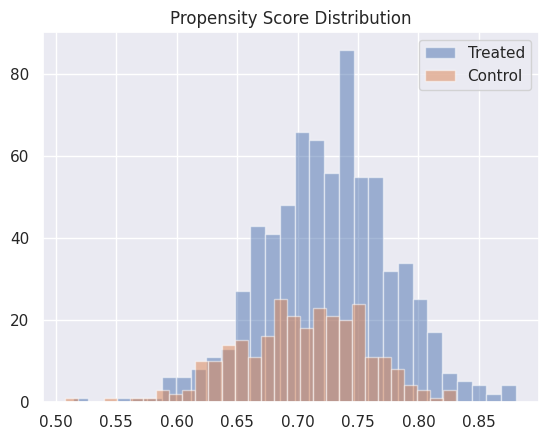

In [ ]:
import matplotlib.pyplot as plt
plt.hist(df[df['T'] == 1]['ps_lcm'], alpha=0.5, label='Treated', bins=30)
plt.hist(df[df['T'] == 0]['ps_lcm'], alpha=0.5, label='Control', bins=30)
plt.legend()
plt.title('Propensity Score Distribution')
plt.show()


In [ ]:
print("Number of treated units:", len(df[df['T'] == 1]))
print("Number of control units:", len(df[df['T'] == 0]))


Number of treated units: 719
Number of control units: 281


In [ ]:
min_ps = df['ps_lcm'].min()
max_ps = df['ps_lcm'].max()
min_ps,max_ps

(0.40067026741951817, 0.9976446736961433)

### N: Causal Forest

Mainly used for heterogenuous treatment effects

In [ ]:
!pip install econml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.3/147.3 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.8
    Uninstalling slicer-0.0.8:
      Successfully uninstalled slicer-0.0.8
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: shap
    Found existing 

In [ ]:
pip install numpy==1.23.3 econml

INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 18.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.

In [ ]:
pip install --upgrade numpy econml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.7 MB/s eta 0:00:00
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.3
    Uninstalling numpy-1.23.3:
      Successfully uninstalled numpy-1.23.3
^C


In [ ]:
from econml.dml import CausalForestDML

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

In [ ]:
#runtime
import time
start_time = time.perf_counter()

In [ ]:
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.3, random_state=42)

causal_forest = CausalForestDML(model_t=RandomForestRegressor(random_state=0), model_y=RandomForestRegressor(random_state=0), n_estimators=100)

causal_forest.fit(Y_train, T_train, X=X_train)

treatment_effects = causal_forest.effect(X_test)

In [ ]:
for _ in range(1000000):
    pass

end_time = time.perf_counter()

execution_time = end_time - start_time

print(f"The code took {execution_time} seconds to run.")

The code took 8.818930801000079 seconds to run.


In [ ]:
treatment_effects

array([1254.0474107 , 1240.04813984, 1230.08018039, 1244.75842193,
       1251.89082582, 1234.9002517 , 1270.51612426, 1253.96533344,
       1236.34117417, 1241.01642685, 1247.96787254, 1230.76019812,
       1247.61011487, 1247.84114066, 1242.47869813, 1240.57544897,
       1228.69870243, 1261.17611602, 1251.46717236, 1244.58850825,
       1261.85353012, 1248.08350816, 1233.04933981, 1243.88257047,
       1248.52648929, 1240.42381188, 1241.24313479, 1237.88991395,
       1229.90884159, 1243.9486414 , 1245.37366088, 1228.42239572,
       1247.65283996, 1233.22235839, 1230.98322856, 1235.07368187,
       1219.21794376, 1236.32514431, 1236.50400721, 1249.8458448 ,
       1227.00155392, 1252.41949264, 1245.96302596, 1238.04455275,
       1248.24187628, 1247.18932714, 1228.31673983, 1228.92007508,
       1238.11243601, 1219.0982289 , 1231.49717641, 1233.42128852,
       1228.67837308, 1254.55827246, 1245.58958019, 1247.13284283,
       1265.77353745, 1261.41593282, 1236.43070595, 1235.87772

In [ ]:
ATE = np.mean(treatment_effects)
print(f"Estimated ATE: {ATE}")

Estimated ATE: 1240.9044450621234


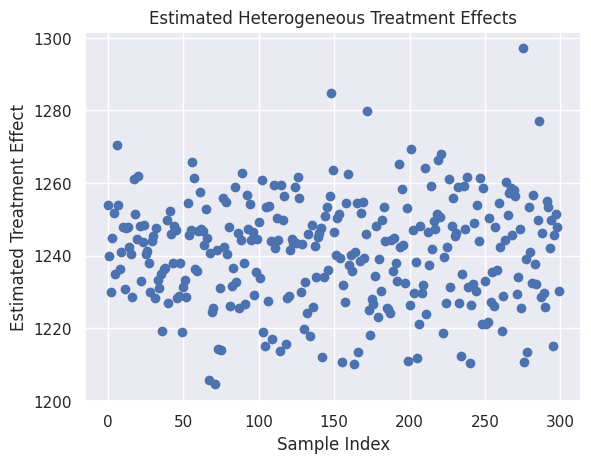

In [ ]:
plt.scatter(range(len(treatment_effects)), treatment_effects)
plt.xlabel('Sample Index')
plt.ylabel('Estimated Treatment Effect')
plt.title('Estimated Heterogeneous Treatment Effects')
plt.show()

### N: Inverse Propensity Weighting

Updated Inverse Propensity Weighting

In [ ]:
#runtime
start_time = time.perf_counter()

In [ ]:
log_reg = LogisticRegression(max_iter=1000, solver='liblinear')
log_reg.fit(X, T)


propensity_scores = log_reg.predict_proba(X)[:, 1]

df['ps'] = propensity_scores

df['weights'] = np.where(df['T'] == 1, 1 / df['ps'], 1 / (1 - df['ps']))

In [ ]:
# Estimate the Weighted Outcome
weighted_treatment_outcome = np.sum(df[df['T'] == 1]['weights'] * df[df['T'] == 1]['Y']) / np.sum(df[df['T'] == 1]['weights'])
weighted_control_outcome = np.sum(df[df['T'] == 0]['weights'] * df[df['T'] == 0]['Y']) / np.sum(df[df['T'] == 0]['weights'])

In [ ]:
for _ in range(1000000):
    pass

end_time = time.perf_counter()

execution_time = end_time - start_time

print(f"The code took {execution_time} seconds to run.")

The code took 1.6535614189999706 seconds to run.


In [ ]:
# Average Treatment Effect (ATE) using IPW
ATE_ipw = weighted_treatment_outcome - weighted_control_outcome
print(f"Average Treatment Effect (ATE) using IPW: {ATE_ipw}")

Average Treatment Effect (ATE) using IPW: 1271.9802801903743


### V: [Genetic Matching](https://ngreifer.github.io/blog/genetic-matching/)

library documentation: https://kosukeimai.github.io/MatchIt/reference/method_genetic.html

In [ ]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr, data

from rpy2.robjects import r
from rpy2.robjects import pandas2ri
import rpy2.robjects as robjects
from rpy2.robjects.vectors import StrVector
pandas2ri.activate()

%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("MatchIt")
install.packages("Matching")
install.packages("rgenoud")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘chk’, ‘RcppProgress’

trying URL 'https://cran.rstudio.com/src/contrib/chk_0.10.0.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/RcppProgress_0.4.2.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/MatchIt_4.7.1.tar.gz'

The downloaded source packages are in
	‘/tmp/Rtmp1mdX6l/downloaded_packages’
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/Matching_4.10-15.tar.gz'
Content type 'application/x-gzip' length 254274 bytes (248 KB)
downloaded 248 KB


The downloaded source packages are in
	‘/tmp/Rtmp1mdX6l/downloaded_packages’
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/rgenoud_5.9-0.11.tar.gz'
Content type 'application/x-gzip' length 727266 bytes (710 KB)
downloaded 710 KB


The downloaded

In [ ]:
%%R
library('MatchIt')
library('dplyr')
library('Matching')
library('rgenoud')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: MASS

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

## 
##  Matching (Version 4.10-15, Build Date: 2024-10-14)
##  See https://www.jsekhon.com for additional documentation.
##  Please cite software as:
##   Jasjeet S. Sekhon. 2011. ``Multivariate and Propensity Score Matching
##   Software with Automated Balance Optimization: The Matching package for R.''
##   Journal of Statistical Software, 42(7): 1-52. 
##

##  rgenoud (Version 5.9-0.11, Build Date: 2024-10-03)
##  See http://sekhon.berkeley.edu/rgenoud for additional documentation.
##  Please cite software as:
##   Walter Mebane, Jr. and Jasjeet S. Sekhon. 2011.
##   ``Genetic Optimization Using Derivatives: The rgenoud package for R.''
##   Journal of Statistical S

In [ ]:
%%R
cols <- c('X0','X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X107', 'X108', 'X109', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X120', 'X121', 'X122', 'X123', 'X124', 'X125', 'X126', 'X127', 'X128', 'X129', 'X130', 'X131', 'X132', 'X133', 'X134', 'X135', 'X136', 'X137', 'X138', 'X139', 'X140', 'X141', 'X142', 'X143', 'X144', 'X145', 'X146', 'X147', 'X148', 'X149')


In [ ]:
# Pass it to R
robjects.globalenv['df'] = pandas2ri.py2rpy(df)
robjects.globalenv['cols'] = StrVector(cols)

In [ ]:
%%R

# Create 'treat' variable from matching_df
treat <- df$T

# Subset covariates based on cols
covs <- df[, cols]

# Combine treat with covariates
df_for_ps <- cbind(treat, covs)

##### Start runtime

In [ ]:
import time

start_time = time.perf_counter()

In [ ]:
%%R

set.seed(0)
# Match for ATT (treated as focal group)
match_att <- matchit_out <- MatchIt::matchit(treat ~ .,data = df_for_ps,method = "genetic",estimand = "ATT",ratio = 1,replace = TRUE,
                                             pop.size = 200)
matched_att <- match.data(match_att)

In [ ]:
%%R

matched_att$Y <- df$Y[match(rownames(matched_att), rownames(df))]
matched_att$T <- df$T[match(rownames(matched_att), rownames(df))]

model_att <- lm(Y ~ T, data = matched_att, weights = weights)
att_est <- coef(model_att)["T"]

In [ ]:
%%R

# Match for ATC (controls as focal group)
match_atc <- matchit_out <- MatchIt::matchit(treat ~ .,data = df_for_ps,method = "genetic",estimand = "ATC",ratio = 1,replace = TRUE,
                                             pop.size = 200)
matched_atc <- match.data(match_atc)

In [ ]:
%%R

matched_atc$Y <- df$Y[match(rownames(matched_atc), rownames(df))]
matched_atc$T <- df$T[match(rownames(matched_atc), rownames(df))]

model_atc <- lm(Y ~ T, data = matched_atc, weights = weights)
atc_est <- coef(model_atc)["T"]

##### End runtime and find ATE

In [ ]:
for _ in range(1000000):
    pass

end_time = time.perf_counter()

execution_time = end_time - start_time

print(f"The code took {execution_time} seconds to run.")

In [ ]:
%%R

# Average them for ATE
ate_est <- (att_est + atc_est) / 2
ate_est

       T 
13.37578 


### Adaptive Hyperboxes

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

def fast_ahb(df, outcome_var, treatment_var, covariates, min_control=5, train_size=0.7,
             expansion_threshold=0.1, random_state=42):
    """
    Fast Adaptive Hyper-Box matching implementation

    Parameters:
    -----------
    df : pandas DataFrame
        The dataset
    outcome_var : str
        Name of the outcome variable
    treatment_var : str
        Name of the treatment variable
    covariates : list
        List of covariate names
    min_control : int
        Minimum number of control units required in each box
    train_size : float
        Proportion of data to use for training the outcome model
    expansion_threshold : float
        Threshold for stopping box expansion when outcome variability increases
    random_state : int
        Random seed for reproducibility

    Returns:
    --------
    dict : Dictionary containing boxes for each test unit and treatment effect estimates
    """

    X = df[covariates]
    y = df[outcome_var]
    T = df[treatment_var]

    X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(
        X, y, T, train_size=train_size, random_state=random_state, stratify=T)


    rf_control = RandomForestRegressor(n_estimators=100, random_state=random_state)
    rf_treated = RandomForestRegressor(n_estimators=100, random_state=random_state)

    rf_control.fit(X_train[T_train == 0][covariates], y_train[T_train == 0])
    rf_treated.fit(X_train[T_train == 1][covariates], y_train[T_train == 1])


    f0_pred = rf_control.predict(X_test[covariates])
    f1_pred = rf_treated.predict(X_test[covariates])


    test_units = X_test.reset_index(drop=True)
    test_treatments = T_test.reset_index(drop=True)
    boxes = []
    matched_groups = []
    ite_estimates = []

    for i in range(len(test_units)):
        unit_i = test_units.iloc[i]
        treatment_i = test_treatments.iloc[i]


        box = {col: [unit_i[col], unit_i[col]] for col in covariates}


        prev_var = 0
        while True:

            in_box = is_in_box(test_units, box)
            units_in_box = test_units[in_box]
            treatments_in_box = test_treatments[in_box]


            n_control = sum(treatments_in_box == 0)
            if n_control >= min_control:

                control_pred = rf_control.predict(units_in_box[covariates])
                treated_pred = rf_treated.predict(units_in_box[covariates])

                current_var = (np.var(control_pred) + np.var(treated_pred)) / 2


                if current_var > prev_var * (1 + expansion_threshold) and n_control >= min_control:
                    break

                prev_var = current_var


            best_dim = None
            best_direction = None
            best_var_increase = float('inf')

            for dim in covariates:

                if any(test_units[dim] < box[dim][0]):
                    next_val = test_units[test_units[dim] < box[dim][0]][dim].max()
                    box_expansion = box.copy()
                    box_expansion[dim] = [next_val, box[dim][1]]


                    new_in_box = is_in_box(test_units, box_expansion)
                    new_units = test_units[new_in_box & ~in_box]

                    if len(new_units) > 0:
                        new_control_pred = rf_control.predict(new_units[covariates])
                        new_treated_pred = rf_treated.predict(new_units[covariates])

                        var_increase = (np.var(new_control_pred) + np.var(new_treated_pred)) / 2

                        if var_increase < best_var_increase:
                            best_var_increase = var_increase
                            best_dim = dim
                            best_direction = 'down'


                if any(test_units[dim] > box[dim][1]):
                    next_val = test_units[test_units[dim] > box[dim][1]][dim].min()
                    box_expansion = box.copy()
                    box_expansion[dim] = [box[dim][0], next_val]


                    new_in_box = is_in_box(test_units, box_expansion)
                    new_units = test_units[new_in_box & ~in_box]

                    if len(new_units) > 0:
                        new_control_pred = rf_control.predict(new_units[covariates])
                        new_treated_pred = rf_treated.predict(new_units[covariates])

                        var_increase = (np.var(new_control_pred) + np.var(new_treated_pred)) / 2

                        if var_increase < best_var_increase:
                            best_var_increase = var_increase
                            best_dim = dim
                            best_direction = 'up'


            if best_dim is None:
                break


            if best_direction == 'down':
                next_val = test_units[test_units[best_dim] < box[best_dim][0]][best_dim].max()
                box[best_dim][0] = next_val
            else:
                next_val = test_units[test_units[best_dim] > box[best_dim][1]][best_dim].min()
                box[best_dim][1] = next_val


            in_box = is_in_box(test_units, box)
            n_control = sum(test_treatments[in_box] == 0)
            if n_control >= min_control and best_var_increase > expansion_threshold * prev_var:
                break


        boxes.append(box)


        final_in_box = is_in_box(test_units, box)
        matched_group = test_units[final_in_box].index.tolist()
        matched_groups.append(matched_group)


        if treatment_i == 1:

            y_obs = y_test.iloc[i]
            control_units = test_units[final_in_box & (test_treatments == 0)]
            if len(control_units) > 0:
                y_cf = np.mean(y_test[control_units.index])
                ite = y_obs - y_cf
            else:
                ite = None
        else:

            y_obs = y_test.iloc[i]
            treated_units = test_units[final_in_box & (test_treatments == 1)]
            if len(treated_units) > 0:
                y_cf = np.mean(y_test[treated_units.index])
                ite = y_cf - y_obs
            else:
                ite = None

        ite_estimates.append(ite)

    # Return results
    results = {
        'boxes': boxes,
        'matched_groups': matched_groups,
        'ite_estimates': ite_estimates,
        'test_indices': X_test.index.tolist(),
        'test_treatments': T_test.tolist()
    }

    return results

def is_in_box(df, box):
    """
    Check which units are in a hyperbox

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing units
    box : dict
        Dictionary with column names as keys and [min, max] as values

    Returns:
    --------
    pandas Series : Boolean series indicating which units are in the box
    """
    in_box = pd.Series([True] * len(df), index=df.index)

    for col, (min_val, max_val) in box.items():
        in_box = in_box & (df[col] >= min_val) & (df[col] <= max_val)

    return in_box


def run_fast_ahb_analysis(df):

    outcome_var = 'murders'
    treatment_var = 'treatment'

    covariates = [col for col in cols_matching if col != 'treatment']

    # Fast AHB
    results = fast_ahb(
        df=df_final,
        outcome_var=outcome_var,
        treatment_var=treatment_var,
        covariates=covariates,
        min_control=3,
        expansion_threshold=0.1,
        random_state=42
    )

    # Calculate ATT
    treated_indices = [i for i, t in enumerate(results['test_treatments']) if t == 1]
    treated_ites = [results['ite_estimates'][i] for i in treated_indices if results['ite_estimates'][i] is not None]

    att = np.mean(treated_ites) if treated_ites else None

    print(f"Estimated ATT: {att}")

    return results, att

In [ ]:
run_fast_ahb_analysis(df_final)

NameError: name 'run_fast_ahb_analysis' is not defined